# Hamiltonian simulation via Trotter decomposition

In this tutorial, users will learn how to use Trotter decomposition in QuAIRKit and how to add Trotter layers into a quantum circuit..

**Table of Contents**
- [Introduction to Trotter decomposition](#Introduction-to-Trotter-decomposition)
- [Circuit Setup](#Circuit-Setup)
- [Verification of Trotter decomposition](#Verification-of-trotter-decomposition)
- [References](#References)

In [1]:
import torch
import numpy as np

import quairkit as qkit
from quairkit import Circuit, Hamiltonian
from quairkit.database import *
from quairkit.qinfo import *

import matplotlib.pyplot as plt

font_family = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = font_family

In [2]:
qkit.set_dtype('complex128')

## Introduction to Trotter decomposition

Trotterization is a critical technique in quantum computing used primarily for simulating the time evolution of system with a given hamiltonian

$$
H = \sum_{i=1}^n H_i.
\tag{1}
$$

where $H_i$ is part of Hamiltonian. Its core idea stems from the Trotter formula, which allows us to decompose a complex Hamiltonian into simpler parts that can be evolved independently over time. In 1996, Seth Lloyd showed that the error in simulating time evolution can be reduced by splitting a whole evolution time  into shorter "time blocks" [1]. By Taylor expansion, we can show that

$$
e^{-iHt} = (\prod_{i=1}^n e^{-iH_i\tau})^r + O(t^2/r)
\tag{2}
$$

where $t$ is the total evolution time, and $r$ is the number of time slices s.t. $r \cdot \tau = t$. This formula is the basis of the Trotter-Suzuki decomposition.

The Trotter-Suzuki formula provides a way to break down complex Hamiltonians into sequences of simpler Hamiltonians that are easier to evolve over time. Although this method introduces some error, it can be controlled by reducing the size of the time steps. In fact, we can further optimize the simulation by using higher order Trotter-Suzuki decompositions, which can be written as

$$
S_1(\tau) = \prod_{i=1}^n e^{-iH_i\tau}, \tag{3}
$$
$$
S_2(\tau) = \prod_{i=1}^n e^{-iH_i\tau/2} \prod_{i=n}^{1} e^{-iH_i\tau/2}, \tag{4}
$$
$$
S_{2k}(\tau) = [S_{2k-2}(p_k\tau)]^2S_{2k-2}((1-4p_k)\tau)[S_{2k-2}(p_k\tau)]^2, \tag{5}
$$

for $k>1,k\in \mathbb{Z}$, where $p_k = 1/(4-4^{1/(2k-1)})$. Importantly, the Trotter-Suzuki decomposition is only formally defined for first-order ($S_1$) and even-order ($S_{2k}$) approximations.

## Circuit Setup

In QuAIRKit, we provide a `TrotterLayer` class to add time-evolving circuits to a user-specified circuit. This circuit could approximate the time-evolving operator of a system given its Hamiltonian $H$, i.e., $U_{\rm cir} = e^{-iHt}$.

Let;s consider a slightly complicated example. We will use the Hamiltonian of two qubits system as an example

$$
H = Z \otimes Z + X \otimes I + Y \otimes X \tag{6}
$$



In [3]:
h = Hamiltonian([[1,'Z0,Z1'], [1,'X0'], [1,'Y0,X1']])
print('The hamiltonian is\n', h)

The hamiltonian is
 1.0 Z0, Z1
1.0 X0
1.0 Y0, X1


In [4]:
print('The matrix form of the hamiltonian is')
h.matrix

The matrix form of the hamiltonian is


tensor([[ 1.+0.j,  0.+0.j,  1.+0.j,  0.-1.j],
        [ 0.+0.j, -1.+0.j,  0.-1.j,  1.+0.j],
        [ 1.+0.j,  0.+1.j, -1.+0.j,  0.+0.j],
        [ 0.+1.j,  1.+0.j,  0.+0.j,  1.+0.j]])

We can add the corresponding Trotter layer with Trotter parameters to a circuit as follows:

The circuit with the Trotter layer with number of steps=2 and order=1


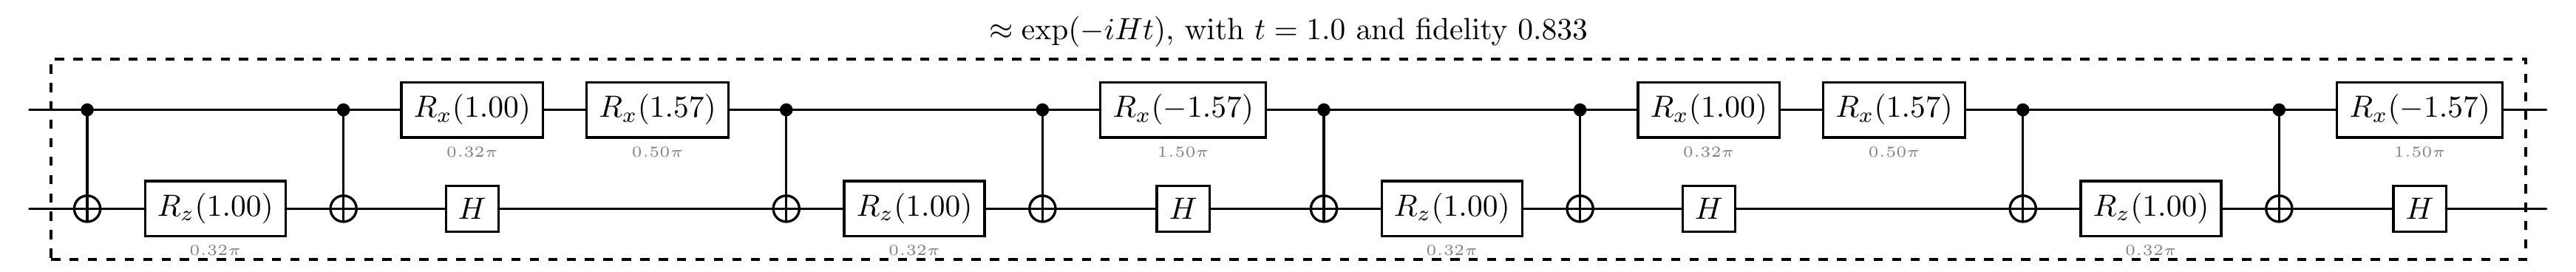

In [5]:
t = 1

cir = Circuit(2)
cir.trotter(h, t, num_steps=2, order=1)
print(f'The circuit with the Trotter layer with number of steps=2 and order=1')
cir.plot('detailed')

We can also determine which qubits in the circuit are used to simulate the corresponding Hamiltonian by specifying the qubit indices.

The repeated section slices in a Trotter circuit.


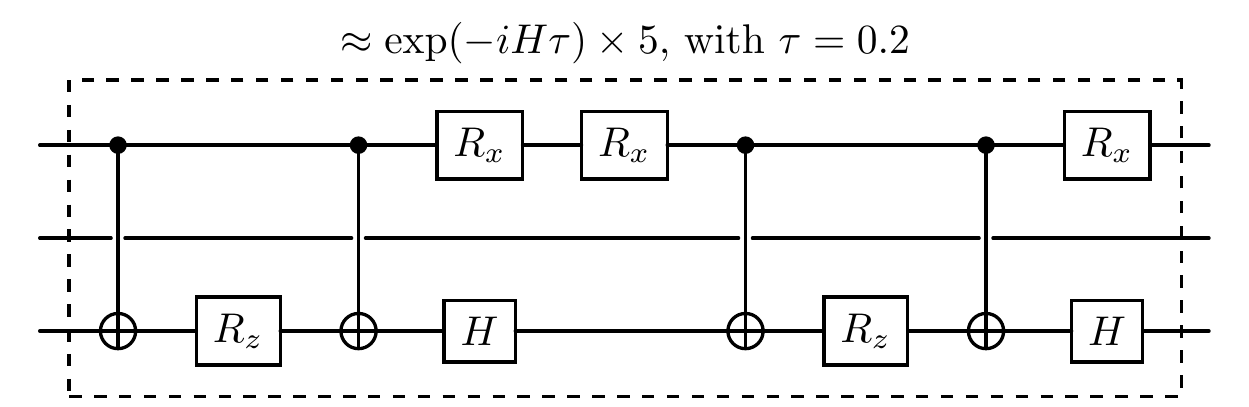

In [6]:
cir = Circuit(3)
cir.trotter(h, t, num_steps=5, qubits_idx=[0, 2])
print(f'The repeated section slices in a Trotter circuit.')
cir.plot('compact')

## Verification of Trotter decomposition

For a real physical system, we often need to calculate the real error in order to determine the circuit depth needed to simulate the system. It can be shown that the error bound on the error for the  2k-th order product formula [2] is：

$$
\epsilon \left( e^{-iHt}, \left(S_{1}(\tau)\right)^r \right) \leq \frac{(tn\Lambda)^2}{r} \exp\left(\frac{|t|n\Lambda}{r}\right) \tag{7}
$$

$$
\epsilon \left( e^{-iHt}, \left(S_{2k}(\tau)\right)^r \right) \leq \frac{\left(2n5^{k-1}\Lambda|t|\right)^{2k+1}}{3r^{2k}} \exp\left(\frac{2n5^{k-1}\Lambda|t|}{r}\right), \quad k \geq 1. \tag{8}
$$

with $\Lambda = \max_i ||H_i||_F$ is the maximum of Frobenius norm of $H_i$. Still consider the same hamiltonian eq.(6), we can calculate the real error of the circuit as follows:

In [7]:
ideal_gate = torch.linalg.matrix_exp(-1j * t * h.matrix)

num_steps = 2
order = 2

cir = Circuit(2)
cir.trotter(h, t, num_steps=num_steps, order=order)

trotter_gate = cir.matrix
fidelity = gate_fidelity(ideal_gate, trotter_gate).item()

print('The fidelity of the circuit is', fidelity)

The fidelity of the circuit is 0.9935372665966202


The error could be further reduced if we further split the evolution process into more 'pieces':

The gate fidelity of Trotter circuit with different number of Trotter steps:


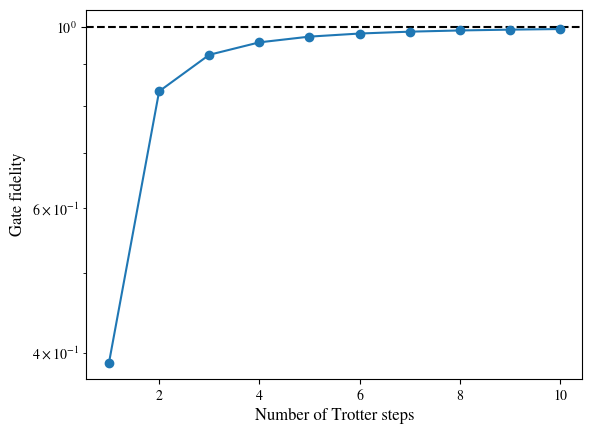

In [8]:
def get_fidelity(n_steps: int) -> float:
    r"""Compute the gate fidelity of the Trotter circuit with n_steps steps.
    
    Args:
        n_steps: Number of Trotter steps.
        
    Returns:
        Gate fidelity of the Trotter circuit.
    """
    t = 1
    cir = Circuit(2)
    cir.trotter(h, t, num_steps=n_steps)
    return gate_fidelity(cir.matrix, ideal_gate).item()

print('The gate fidelity of Trotter circuit with different number of Trotter steps:')
plt.axhline(1, ls='--', color='black')
plt.semilogy(np.arange(1, 11), [get_fidelity(r) for r in np.arange(1, 11)], 'o-')
plt.xlabel('Number of Trotter steps', fontsize=12)
plt.ylabel('Gate fidelity', fontsize=12)
plt.show()

---

## References

[1] Lloyd, Seth. "Universal quantum simulators." Science 273.5278 (1996): 1073-1078.

[2] "Hamiltonian Simulation." [PaddleQuantum Tutorials](https://www.quair.group/software/pq/tutorials/quantum_simulation/hamiltoniansimulation_en), QuAIR Group. Accessed 26 May 2025.

*Table: A reference of notation conventions in this tutorial.*

| Symbol        | Variant          | Description                               |
|:---------------:|:------------------:|-------------------------------------------|
|$H$| $H_i$ | Hamiltonian (term)|
|$n$|  | total number of Hamiltonian terms |
|$X, Y, Z$  |  | Pauli operators  |
|$r$  |  | Trotter steps  |
|$t$| $\tau$ | evolution time (at each step) |
|$S_k(\tau)$| | $k$-th order Trotter-Suzuki decomposition for $e^{-iH\tau}$ |
|$\|\|\cdot\|\|_F$  |  | Frobenius norm|
|$\Lambda$| | the maximum of $\|\|H_i\|\|_F$  |

In [9]:
qkit.print_info()


---------VERSION---------
quairkit: 0.4.0
torch: 2.7.0+cpu
numpy: 1.26.0
scipy: 1.14.1
matplotlib: 3.10.0
---------SYSTEM---------
Python version: 3.10.16
OS: Windows
OS version: 10.0.26100
---------DEVICE---------
CPU: ARMv8 (64-bit) Family 8 Model 1 Revision 201, Qualcomm Technologies Inc
